In [1]:
from lib.video_dataset import VideoFrameDataset
from config.torch_config import get_transform
from config.dataset import get_dataset_path

c:\Users\Ivan\Documents\Projects\TFG\ubu-sign2text\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys

sys.path.append("../")

from common.config.torch_config import device, unnormalize
from common.utils.output import plot_tensor, plot_train_val_data

## HYPERPARAMETERS

In [3]:
from config.const import *

In [4]:
data_path, model_path = get_dataset_path(dataset="WLASL/videos", model_name="WLASL_5")
multiple_transform = get_transform(IMAGE_SIZE, IMAGE_RANDOM_CROP_RESIZE)

In [5]:
dataset = VideoFrameDataset(
    root_path=data_path,
    transform=multiple_transform,
    num_segments=NUM_SEGMENTS,
    frames_per_segment=FRAMES_PER_SEGMENT,
)

classes = dataset.classes
print(classes)

['before', 'book', 'chair', 'computer', 'drink']


In [6]:
from utils.loader import split_dataset

In [7]:
train_loader, test_loader, validation_loader = split_dataset(
    dataset, train_split=0.70, validation_split=0.1, batch_size=BATCH_SIZE
)

In [8]:
print(len(train_loader), len(validation_loader), len(test_loader))

7 1 2


### Example of input of net.

> Initial input = [BATCH_SIZE, NUMBER_OF_FRAMES, CHANNELS, HEIGHT, WIDTH]

This example shows first example (first video) in first batch

In [9]:
from torchvision.utils import make_grid
from torch import nn

In [10]:
def plot_grid(
    tensor,
    dims=(1, 2, 0),
    nrow=FRAMES_PER_SEGMENT * NUM_SEGMENTS,
    norm=True,
    start_dim=0,
    end_dim=1,
):
    flat = nn.Flatten(start_dim=start_dim, end_dim=end_dim)  # Flatten batch to plot.

    flatted_tensor = flat(tensor)
    grid = make_grid(flatted_tensor.cpu(), nrow=nrow)

    if norm:
        grid = unnormalize(grid)

    plot_tensor(grid, dims)

### Show input of the net (entire batch)

In [11]:
first_batch = next(iter(train_loader))[0]
plot_grid(first_batch)

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\Ivan\Documents\Projects\TFG\ubu-sign2text\venv\lib\site-packages\torch\utils\data\_utils\worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\Ivan\Documents\Projects\TFG\ubu-sign2text\venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\Ivan\Documents\Projects\TFG\ubu-sign2text\venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\Ivan\Documents\Projects\TFG\ubu-sign2text\src\nets\simple_net\lib\video_dataset.py", line 141, in __getitem__
    return self._get(record, frame_start_indices)
  File "c:\Users\Ivan\Documents\Projects\TFG\ubu-sign2text\src\nets\simple_net\lib\video_dataset.py", line 124, in _get
    image = self._load_image(record.path, start_index + i)
  File "c:\Users\Ivan\Documents\Projects\TFG\ubu-sign2text\src\nets\simple_net\lib\video_dataset.py", line 91, in _load_image
    return Image.open(
  File "c:\Users\Ivan\Documents\Projects\TFG\ubu-sign2text\venv\lib\site-packages\PIL\Image.py", line 2953, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Ivan\\Documents\\Projects\\TFG\\ubu-sign2text\\data\\WLASL\\videos\\book\\0006\\img_00101.png'


### The net will then make first and second convolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 16, 2, 100, 100])
torch.Size([16, 32, 1, 50, 50])


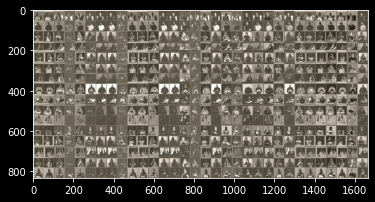

In [ ]:
hidden_1, hidden_2 = 16, 32

conv1 = nn.Conv3d(
    FRAMES_PER_SEGMENT * NUM_SEGMENTS,
    hidden_1,
    kernel_size=(2, 3, 3),
    stride=2,
    padding=1,
)
conv2 = nn.Conv3d(hidden_1, hidden_2, kernel_size=3, stride=2, padding=1)
relu = nn.LeakyReLU()
batch_1 = nn.BatchNorm3d(hidden_1)
batch_2 = nn.BatchNorm3d(hidden_2)

x = first_batch

x = conv1(x)
x = relu(x)
x = batch_1(x)

print(x.shape)

x = conv2(x)
x = relu(x)
x = batch_2(x)

print(x.shape)


plot_grid(x, nrow=hidden_2)

## Check balance status of the loaders

In [ ]:
# from nets.common.utils.balance import check_balance_status

# print(check_balance_status(test_loader, classes))
# print(check_balance_status(validation_loader, classes))
# print(check_balance_status(train_loader, classes))

In [ ]:
from lib.model import CNN

model = CNN(
    num_classes=len(classes),
    num_frames=FRAMES_PER_SEGMENT * NUM_SEGMENTS,
    image_size=int(IMAGE_SIZE * IMAGE_RANDOM_CROP_RESIZE),
)

# print(model)

In [ ]:
from lib.complex_model import InceptionI3d

model = InceptionI3d(len(classes), in_channels=FRAMES_PER_SEGMENT * NUM_SEGMENTS)

In [ ]:
from lib.train import train_model

In [ ]:
train_costs, val_costs, train_accs, val_accs = train_model(
    model,
    train_loader,
    validation_loader,
    device,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
)

Training on device: cuda


RuntimeError: input image (T: 1 H: 7 W: 7) smaller than kernel size (kT: 2 kH: 7 kW: 7)

In [ ]:
plot_train_val_data(train_costs, val_costs, ylabel="Costs")
plot_train_val_data(train_accs, val_accs, ylabel="Accuracy")

In [ ]:
import sys

sys.path.append("../")

from common.utils.check_accuracy import check_accuracy

## Probamos el acc con el dataset de prueba reservado

In [ ]:
check_accuracy(train_loader, model, classes, device, n_batchs=10)

In [ ]:
check_accuracy(validation_loader, model, classes, device)

In [ ]:
check_accuracy(test_loader, model, classes, device)

## Exportamos modelo

In [ ]:
from torch import save

In [ ]:
save(model, model_path)
print(f"Model exported to {model_path}")